# Making Plots with JuliaDB and OnlineStats

Plotting in JuliaDB is achieved through [StatPlots.jl](https://github.com/JuliaPlots/StatPlots.jl) and recipes in [OnlineStats](https://github.com/joshday/OnlineStats.jl).

In [3]:
using Distributed

addprocs()

using JuliaDB, OnlineStats, StatsPlots

gr()

Plots.GRBackend()

## Plotting with [StatPlots.jl](https://github.com/JuliaPlots/StatPlots.jl)

All the power and flexibility of [Plots](https://github.com/JuliaPlots/Plots.jl) is made available to JuliaDB with StatPlots and the `@df` macro.

<div class="alert alert-warning">
<strong>Warning!</strong>  StatPlots will not work on distributed table/ndsparse objects.
</div>

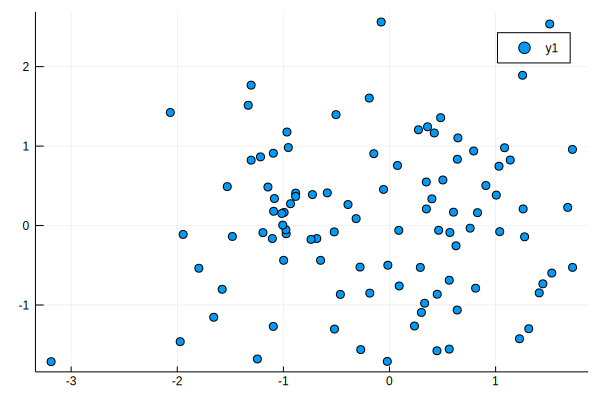

In [5]:
t = table((x = randn(100), y = randn(100)))

@df t scatter(:x, :y)

## Plotting Big Data with `partitionplot`


Suppose we have a billion observations.  Visualizing a large amount of data is hard on 

1. Your GPU
2. Your Brain

The idea behind `partitionplot` is this:  Instead of plotting individual observations, observations on the x-axis are grouped together and a summary of the data is displayed on the y-axis.  We can then make an easier-to-create/easier-to-comprehend plot.

```
partitionplot(table, [x,] y; stat, nparts)
```

Keyword args:
- `stat`: OnlineStat used to summarize the `y` over a section of `x`
    - Default: `Extrema(Type_of_Y)`
- `nparts`: Number of parts to group `x` into
    - Default: `100`

In [18]:
using RDatasets, Tables

diamonds = table(dataset("ggplot2", "diamonds"), pkey=:Carat)

Table with 53940 rows, 10 columns:
Columns:
#   colname  type
─────────────────────────────────────
1   Carat    Float64
2   Cut      CategoricalString{UInt8}
3   Color    CategoricalString{UInt8}
4   Clarity  CategoricalString{UInt8}
5   Depth    Float64
6   Table    Float64
7   Price    Int32
8   X        Float64
9   Y        Float64
10  Z        Float64

### If only one selection is provided, the x axis is "Number of Observations"

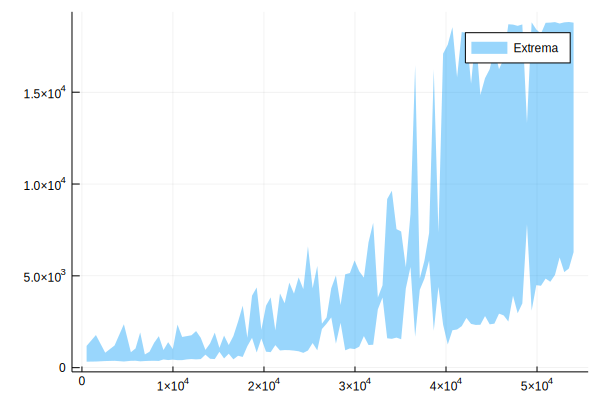

In [19]:
partitionplot(diamonds, :Price)

### If two selections are provided (X and Y)

- X will be adaptively grouped together
- The `stat` of Y will be plotted over each group of X

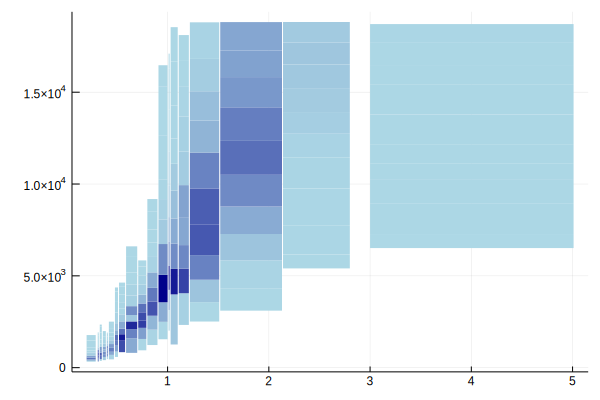

In [21]:
partitionplot(diamonds, :Carat, :Price; stat=KHist(10), color=:blues, nparts=20)

┌ Warning: `Hist(b::Int)` is deprecated, use `KHist(b::Int)` instead.
│   caller = top-level scope at In[22]:1
└ @ Core In[22]:1


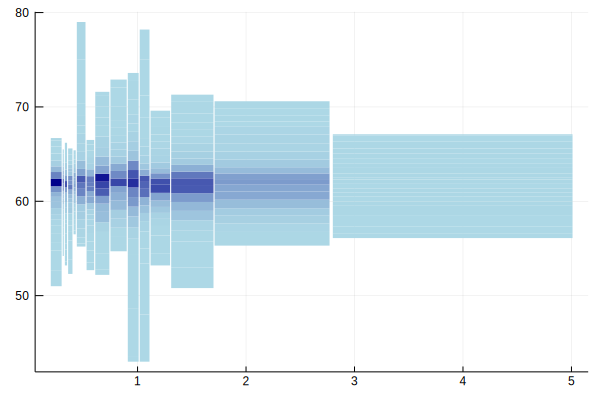

In [22]:
partitionplot(diamonds, :Carat, :Depth, stat=Hist(20), nparts=15, color=:blues)

In [23]:
partitionplot(diamonds, :Cut, :Color, stat=CountMap(String))

┌ Warning: `eltype(x::CategoricalString)` is deprecated, use `eltype(String(x))` instead.
│   caller = fit! at OnlineStatsBase.jl:108 [inlined]
└ @ Core /Users/joshday/.julia/packages/OnlineStatsBase/L6i9N/src/OnlineStatsBase.jl:108
┌ Warning: `iterate(x::CategoricalString)` is deprecated, use `iterate(String(x))` instead.
│   caller = fit! at OnlineStatsBase.jl:109 [inlined]
└ @ Core /Users/joshday/.julia/packages/OnlineStatsBase/L6i9N/src/OnlineStatsBase.jl:109


ErrorException: The input for CountMap is a String.  Found Char.

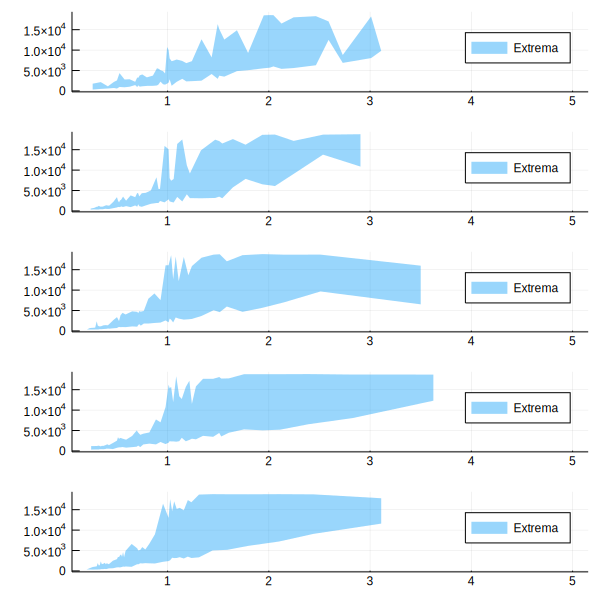

In [24]:
partitionplot(diamonds, :Carat, :Price, by=:Cut, stat=Extrema(), nparts=50,
    layout=(5,1), link = :all, size=(600,600))

# Missing Data

<div class="alert alert-warning">
<strong>Warning!</strong>  <code>partitionplot</code> automatically skips missing values!
</div>

In [25]:
using DataValues
t = table(DataValueArray(randn(10^6), rand(Bool, 10^6)), randn(10^6))

ArgumentError: ArgumentError: Package DataValues not found in current path:
- Run `import Pkg; Pkg.add("DataValues")` to install the DataValues package.


In [ ]:
partitionplot(t, 1, 2, stat = Hist(-5:.1:5), color = :viridis)

# Mosaic Plot

In [ ]:
plot(reduce(Mosaic(String,String), diamonds, select = (:cut, :color)))

# PlotNN (plot a numerical X vs. numerical Y)

```
PlotNN(nbins)
```

- Approximate scatterplot 

<div class="alert alert-warning">
<strong>Warning!</strong>  The current implementation is quite slow!  <code>partitionplot</code> with <code>stat=Hist(...)</code> is a better option.
</div>

In [ ]:
plot(reduce(PlotNN(100), diamonds, select = (:carat, :price)))